In [13]:
import numpy as np
import tensorflow
import keras
from keras import layers

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import sys
np.set_printoptions(threshold=sys.maxsize)

from pythonosc import udp_client

import statistics

In [14]:
epoch_step = 0
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print('x_train shape:', x_train.shape)
# print(x_train.shape[0], "train samples")
# print(x_test.shape[0], "test samples")

print(y_train.shape)

x_100 = np.concatenate([x_train[(y_train == 1)[:]][:50], x_train[(y_train == 9)[:]][:50]])



y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

b = np.argmax(y_train, axis=1)

x_train shape: (60000, 28, 28, 1)
(60000,)


In [15]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),  
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),  
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),  
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(20, activation='relu', kernel_initializer='he_uniform'),
        layers.Dense(num_classes, activation='softmax'),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                 

In [16]:
client = udp_client.SimpleUDPClient('127.0.0.1', 7777)


class outs1(keras.callbacks.Callback):

    def on_train_begin(self, epoch, logs=None):
        global epoch_step
        epoch_step = 1
        
        client.send_message('/ON', 1)
        print(model.outputs[0])

        
    
    def on_epoch_end(self, epoch, logs=None):
        global epoch_step
        epoch_step += 1

    def on_batch_end(self, batch, logs={}):          
               
        from keras import backend as K
        from IPython.display import clear_output

        if batch % 20 == 0:
            clear_output(wait=True)

            fig, axes = plt.subplots(12,5)


            inp = model.input
            outputs = [layer.output for layer in model.layers]
            functors = [K.function([inp], [out]) for out in outputs]
            
            
            layer_outs_2 = [func(x_100) for func in functors]
            
            
            x_100_flattened = layer_outs_2[0][0]
            metric = np.zeros((100, 100))
            for i in range(100):
                for j in range(100):
                    metric[i,j] = np.linalg.norm(x_100_flattened[i] - x_100_flattened[j])         



            x_100_flattened_2 = layer_outs_2[-2][0]
            metric_2 = np.zeros((100, 100))
            for i in range(100):
                for j in range(100):
                    metric_2[i,j] = np.linalg.norm(x_100_flattened_2[i] - x_100_flattened_2[j])

                    #metric[i,j] = np.dot(x_100_flattened[i], x_100_flattened[j])
            

            x_100_flattened_3 = layer_outs_2[-1][0]
            metric_3 = np.zeros((100, 100))
            for i in range(100):
                for j in range(100):
                    metric_3[i,j] = np.linalg.norm(x_100_flattened_3[i] - x_100_flattened_3[j])
            
            a = np.sum(metric_3[:50,:50]) / 50**2
            b = np.sum(metric_3[:50,50:]) / 50**2
            c = np.sum(metric_3[50:,:50]) / 50**2
            d = np.sum(metric_3[50:,50:]) / 50**2

            a_std = np.std(metric_3[:50,:50])
            b_std = np.std(metric_3[:50,50:])
            c_std = np.std(metric_3[50:,:50])
            d_std = np.std(metric_3[50:,50:])

            e = b - a
            f = c - d

            # print('\n', e, f)


            client.send_message('/e', e)
            client.send_message('/f', f)
            
            
            loss_osc = logs.get('loss')
            acc_osc = logs.get('accuracy')
            client.send_message('/loss', loss_osc)
            client.send_message('/acc', acc_osc)            
            
            for i in range(12):
                layer_outs_1 = [func([x_test[i][np.newaxis,...]]) for func in functors]

                axes[i,0].imshow(x_test[i], cmap='viridis')
                axes[i,1].imshow(layer_outs_1[0][0][0,:,:,0], cmap='viridis')
                axes[i,2].imshow(layer_outs_1[3][0][0,:,:,0], cmap='viridis')
                axes[i,3].imshow(layer_outs_1[5][0][0,:,:,0], cmap='viridis')
                axes[i,4].imshow(layer_outs_1[-1][0][:,:], cmap='viridis')

                valued_array = layer_outs_1[-1][0][:,:]
                large_values = np.where(valued_array>0.05, valued_array, 0)
                large_values = large_values.flatten()


                client.send_message('/array{0}'.format(i), large_values.tolist()[:])
            
            for i in range(12):
                for j in range(5):
                    axes[i,j].axis('off')
                    axes[i,j].set_xticks([])
                    axes[i,j].set_yticks([])
                
            # axes[0].imshow(x_test[100], cmap='viridis')
            # axes[1].imshow(layer_outs_1[0][0][0,:,:,0], cmap='viridis')
            # axes[2].imshow(layer_outs_1[5][0][0,:,:,0], cmap='viridis')
            # axes[3].imshow(metric, cmap='viridis')
            # axes[4].imshow(metric_2, cmap='viridis')
            # axes[5].imshow(metric_3, cmap='viridis')
            # axes[6].imshow(layer_outs_1[-1][0][:,:], cmap='viridis')

            fig.set_figheight(15)
            fig.set_figwidth(8)

           
            plt.show()

    def on_train_end(self, logs=None):
        client.send_message('/ON', 0)
            



In [17]:
# class outs1(keras.callbacks.Callback):

#     def on_train_begin(self, epoch, logs=None):
#         global epoch_step
#         epoch_step = 1
        


#     def on_batch_end(self, batch, logs={}):                 
#         print(model.layers[3].output)

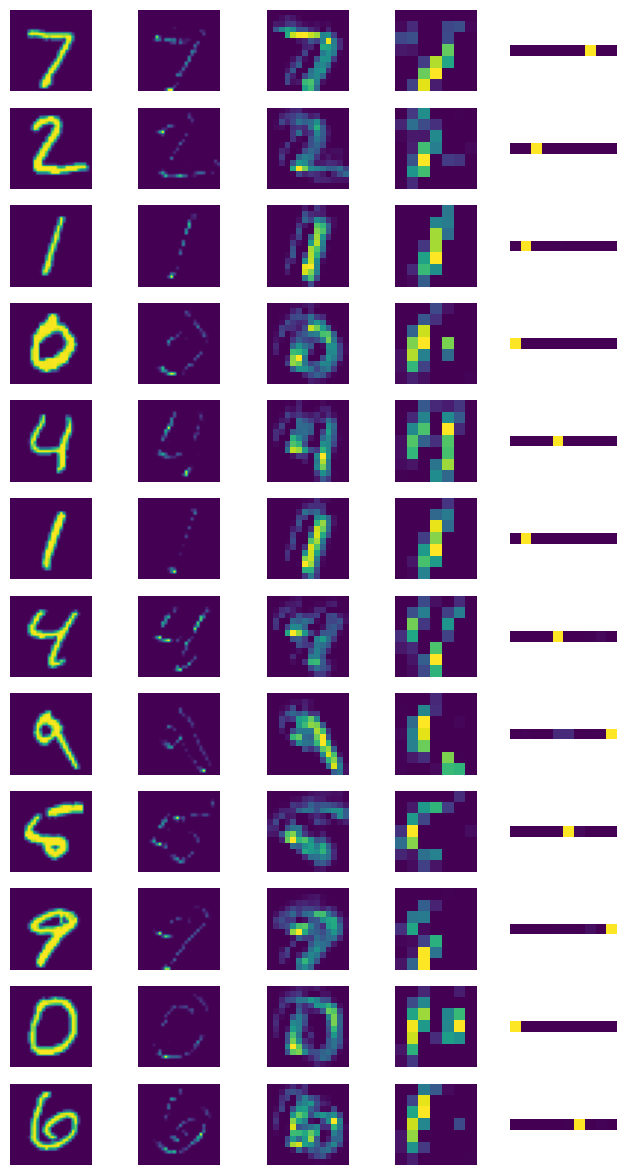

849/938 [==========================>...] - ETA: 5s - loss: 0.2337 - accuracy: 0.9310

KeyboardInterrupt: 

In [18]:
callbacks_list = [outs1()]


batch_size = 64
epochs = 30

model(keras.Input(shape=input_shape))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.000005,
    decay_steps=10000,
    decay_rate=0.8) #higher decay rate means slower decay

opt = keras.optimizers.Adam(learning_rate=0.00001) #0.0000025 std; 0.00001 demo; lr 0.000005 -> ~3min | lr 0.000001 -> >20min | lr lr_schedule: (0.000005; 10000; 0.9) -> ~10min | lr lr_schedule: (0.000005; 10000; 0.95) -> ~8min

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1, callbacks=callbacks_list)